In [1]:
from ogb.graphproppred.dataset_pyg import PygGraphPropPredDataset

# Download and process data at './dataset/'
dataset_molhiv = PygGraphPropPredDataset(name = 'ogbg-molhiv')

dataset_molpcba = PygGraphPropPredDataset(name = 'ogbg-molpcba')

dataset_ppa = PygGraphPropPredDataset(name = 'ogbg-ppa')

In [ ]:
print(f"num of labels in molhiv: {dataset_molhiv.num_classes}")
print(f"num of features of nodes in molhiv: {dataset_molhiv.num_node_features}")
print(f"num of features of edges in molhiv: {dataset_molhiv.num_edge_features}")

print(f"num of labels in molpcba: {dataset_molpcba.num_classes}")
print(f"num of features of nodes in molpcba: {dataset_molpcba.num_node_features}")
print(f"num of features of edges in molpcba: {dataset_molpcba.num_edge_features}")

print(f"num of labels in molppa: {dataset_ppa.num_classes}")
print(f"num of features of nodes in molppa: {dataset_ppa.num_node_features}")
print(f"num of features of edges in molppa: {dataset_ppa.num_edge_features}")

num of labels in molhiv: 2
num of features of nodes in molhiv: 9
num of features of edges in molhiv: 3
num of labels in molpcba: 2
num of features of nodes in molpcba: 9
num of features of edges in molpcba: 3
num of labels in molppa: 37
num of features of nodes in molppa: 0
num of features of edges in molppa: 7


In [ ]:
dataset_molhiv.get_summary()
dataset_molpcba.get_summary()
dataset_ppa.get_summary()

100%|██████████| 158100/158100 [00:06<00:00, 23513.13it/s]


PygGraphPropPredDataset (#graphs=158100):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |    243.4 |   4532.2 |
| std        |     85.4 |   2615.3 |
| min        |     50   |    108   |
| quantile25 |    182   |   2960   |
| median     |    300   |   4274   |
| quantile75 |    300   |   5716   |
| max        |    300   |  36138   |
+------------+----------+----------+

In [ ]:
print(f"example data of dataset_molhiv: {dataset_molhiv[0]}")
print(f"example data of dataset_molpca: {dataset_molpcba[0]}")
print(f"example data of dataset_ppa: {dataset_ppa[0]}")

example data of dataset_molhiv: Data(edge_index=[2, 40], edge_attr=[40, 3], x=[19, 9], y=[1, 1], num_nodes=19)
example data of dataset_molpca: Data(edge_index=[2, 44], edge_attr=[44, 3], x=[20, 9], y=[1, 128], num_nodes=20)
example data of dataset_ppa: Data(edge_index=[2, 4408], edge_attr=[4408, 7], y=[1, 1], num_nodes=300)


In [2]:
from src.sampling.Sampling import sampling_graph_classification

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.autograd import Variable
from src.supervised_NDL.SMF_BCD import SDL_BCD
from src.supervised_NDL.SMF_torch import smf

k= 2

# X , y = sampling_graph_classification(dataset = dataset_ppa, k = k, sample_size=1, 
#                                           has_edge_feature=True)

X , y = sampling_graph_classification(dataset = dataset_molhiv, k = k, sample_size=1, 
                                          has_edge_feature=True, has_node_feature=True)

Accuracy = []
test_size = 0.5

X_train, X_test, Y_train, Y_test = train_test_split(X.T, y.T, test_size=test_size, random_state=2)
# print(X_train.shape)
# print(Y_train.shape)

X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(Y_train)).long()
X_test = Variable(torch.from_numpy(X_test)).float()
y_test = Variable(torch.from_numpy(Y_test)).long()
# print(f"y_train's ndim: {y_train.ndim}")
# print(f"y_test: {y_test.shape}")

smf_model = smf(X_train, y_train, hidden_size=k, device='cuda')
results_dict = smf_model.fit(num_epochs=100,
               lr_classification=0.01,
               lr_matrix_factorization=0.01,
               xi=1,
               initialize='spectral',
               W_nonnegativity=True,
               H_nonnegativity=True,
               test_data=[X_test, y_test],
               record_recons_error=True)

W = results_dict.get('loading')[0]
beta= results_dict.get('loading')[1]
H = results_dict.get('code')

--- Training --- [threshold, AUC] =  [0.921, 0.491]
--- Iteration -1: Training loss --- [Data, Label, Total] = [270529.761658.3, 56692.104100.3, 327221.865758.3]
Epoch [10/100],Elapsed_time: 0.39469218254089355,Loss_Classification: 7438.3779 Loss_MF: 0.4555
mythre= 0.92137134
mythre_test= 0.037823472
Test accuracy = 0.966, Test AUC = 0.493
--- Training --- [threshold, AUC] =  [0.036, 0.509]
--- Iteration 9: Training loss --- [Data, Label, Total] = [312734.348206.3, 3213.987249.3, 315948.335455.3]
Epoch [20/100],Elapsed_time: 0.7621128559112549,Loss_Classification: 7438.3779 Loss_MF: 0.4178
mythre= 0.035744824
mythre_test= 0.037823472
Test accuracy = 0.282, Test AUC = 0.493
--- Training --- [threshold, AUC] =  [0.036, 0.509]
--- Iteration 19: Training loss --- [Data, Label, Total] = [291307.397658.3, 3213.987249.3, 294521.384907.3]
Epoch [30/100],Elapsed_time: 1.1427223682403564,Loss_Classification: 7438.3779 Loss_MF: 0.4133
mythre= 0.035744824
mythre_test= 0.037823472
Test accuracy = 0

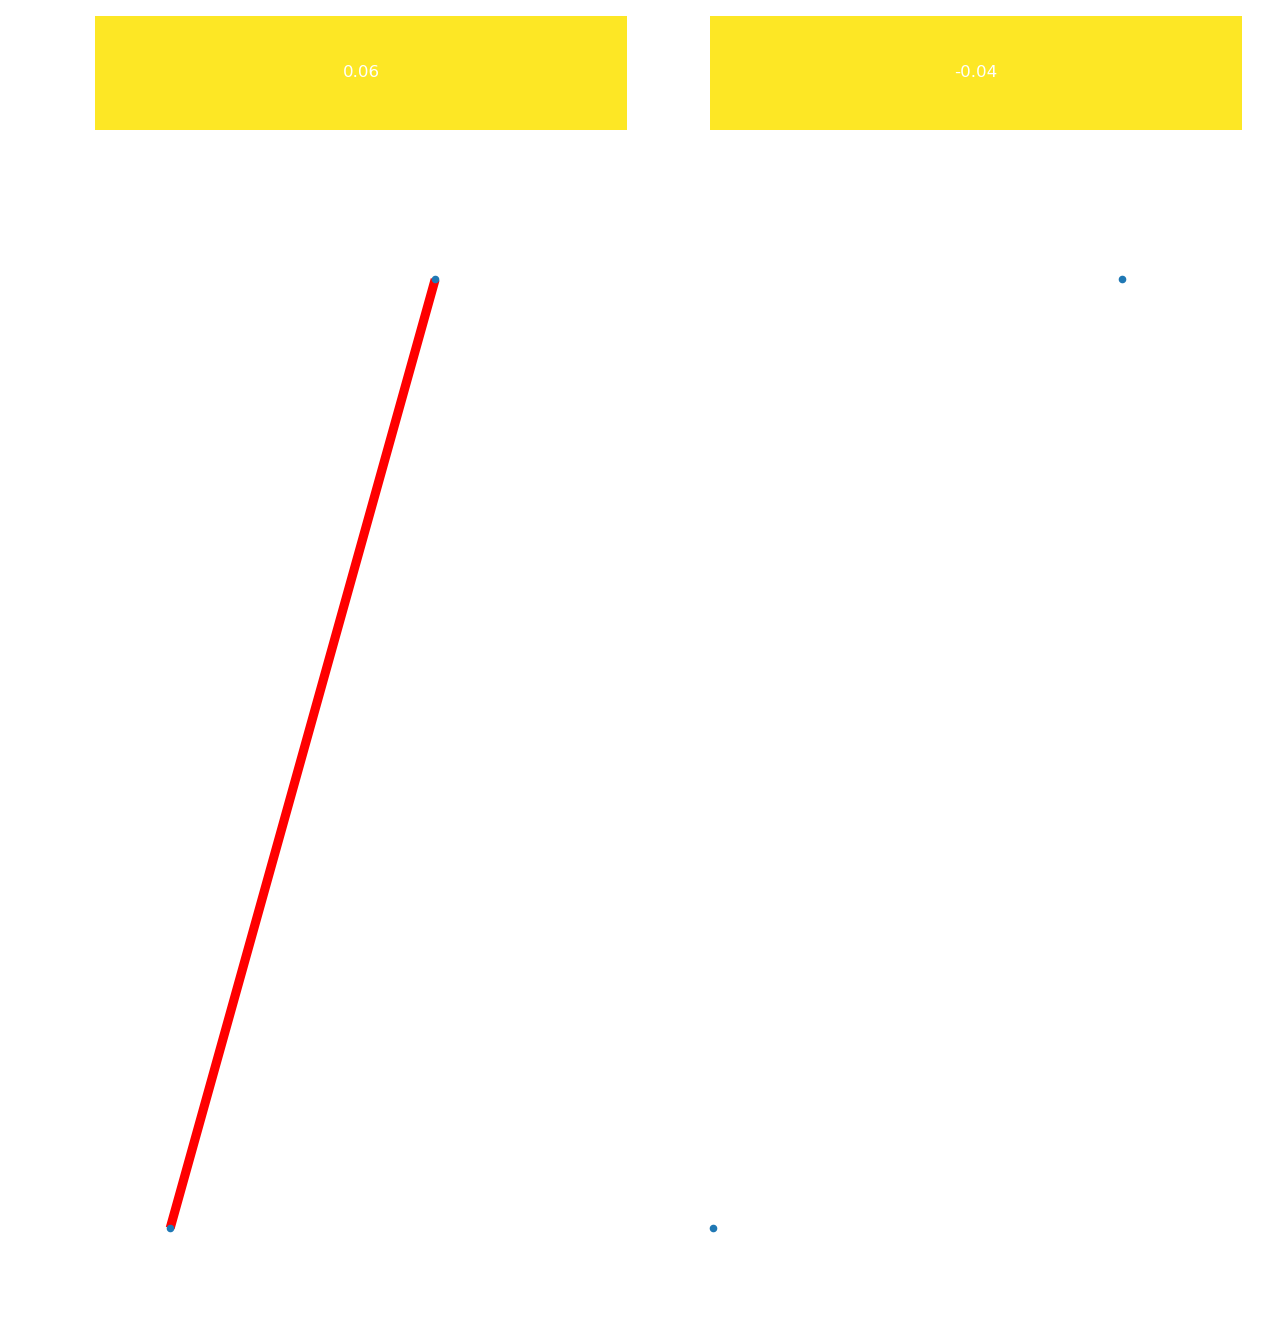

In [6]:
from util.plotting  import *

display_dict_and_graph(save_path=f'output/figure/ogbg_ppa', W=W[:k**2], regression_coeff=beta.T, fig_size=[15,15], plot_graph_only=True)